# Isolation Forest + VAE

## 1. Import basic libraries

In [0]:
%%capture
#Install skorch package 
!pip install skorch

In [0]:
#Data managment 
import pandas as pd 
import numpy as np 

#Vizualization 
from matplotlib import pyplot as plt

#Torch
import torch
from torch import nn, optim
import torch.nn.functional as F
from torch.utils import data as data_lib

#Utilities
import os

## 2. Download Preprocessed Data

In [0]:
%%capture
#Get data
if not os.path.isfile('train_data.csv'):
    !wget 'https://drive.google.com/uc?export=download&id=1ESF8oUoZMHOM5VXte4vlhM1_-p_Yxa2k' -O train_data.csv
if not os.path.isfile('test_data.csv'): 
    !wget 'https://drive.google.com/uc?export=download&id=1VjghtXl1OuZy4MGf995Zq34YSOP3Rf8p' -O test_data.csv

## 3. Parse Data

In [38]:
train_data = pd.read_csv('train_data.csv')
train_data = train_data.drop(train_data.columns[0], axis=1) #Drop original index
y_train = train_data['label']
X_train = train_data.drop('label', axis = 1) 

no_features = X_train.shape[1]

print(y_train.value_counts())
X_train.head()

0.0    2582
1.0      31
Name: label, dtype: int64


,dcar_posA_2_Err,slopedZAchi2Pos,MIPattachSlopeC,meanMultNeg,mediumPtAPos,dcarCP0,dcaz_negA_1_Err,tpcConstrainPhiA,dcar_negA_chi2,offsetdZC,dcaz_negA_0_Err,zPullHighPt,vertOK,tpcItsMatchHighPtA,deltaPt,resolutionMIP,entriesVertY,entriesMult,dcaz_posA_0,dcar_posC_1,slopedRAchi2Pos,tpcConstrainPhiC,iroc_A_side,meanVertZ,slopedZAchi2,deltaPtC,offsetdZAErr,offsetdZA,dcaz_posA_2_Err,dcaz_negC_0_Err,offsetdRA,meanMIPele,offsetdZAchi2Pos,medianHVandPTGainCorrIROC,iroc_C_side,vertAll,dcar_negA_1_Err,offsetdRAchi2Pos,meanMult,qOverPtC,...,phiPull,rmsTPCChi2,dcar_negC_1_Err,offsetdRCchi2,meanTPCChi2,rmsVertY,tpcItsMatchHighPtC,dcaz_negC_2_Err,yPullHighPt,tpcItsMatchC,deltaPtchi2C,deltaPtchi2,rmsMultNeg,meanTPCnclF,ptPullHighPt,oroc_C_side,slopedZCchi2Pos,rmsTPCncl,dcar_posC_2_Err,offsetdZCchi2Pos,deltaPtchi2A,resolutionMIPele,dcarCP1,dcar_posA_1_Err,slopedRCchi2Pos,slopeCTPCnclFErr,slopeCTPCnclF,dcar_negC_0_Err,slopedZC,lambdaPull,dcaz_posC_1_Err,offsetdRCchi2Neg,dcaz_negC_chi2,offsetdRCchi2Pos,dcaz_posC_0_Err,oroc_A_side,offsetdZAchi2,dcar_negA_0_Err,dcar_negC_chi2,slopeATPCnclF
0,0.099409,0.014310,0.801887,0.222395,0.287348,0.015659,0.090696,0.250600,0.023914,0.681802,0.093288,0.536037,0.048471,0.484353,0.830216,0.084010,0.048471,0.048471,0.286951,0.716267,0.023016,0.343302,1.0,0.470134,0.007945,0.639889,0.043615,0.615646,0.100054,0.084979,0.748467,0.538374,0.014310,0.634857,1.0,0.048232,0.100657,0.023016,0.236333,0.999787,...,0.261710,0.396997,0.108241,0.180049,0.408427,0.334197,0.513542,0.087115,0.411626,0.486461,0.185221,0.251164,0.269275,0.628099,0.500062,1.0,0.083777,0.188709,0.076326,0.083777,0.560022,0.376559,0.865777,0.108347,0.158491,0.615037,0.615037,0.111798,0.671210,0.544371,0.082443,0.226467,0.036121,0.158491,0.079352,1.0,0.007945,0.109410,0.046268,0.336805
1,0.099385,0.033617,0.808663,0.223777,0.275670,0.014604,0.090423,0.252088,0.042604,0.631552,0.092961,0.596938,0.048533,0.507080,0.726710,0.075907,0.048533,0.048533,0.276645,0.716802,0.037232,0.347691,1.0,0.544646,0.061303,0.589440,0.043206,0.607734,0.099591,0.084341,0.740841,0.539351,0.033617,0.577720,1.0,0.048154,0.099989,0.037232,0.237175,0.999787,...,0.282124,0.365360,0.107216,0.179455,0.392618,0.271104,0.504607,0.086553,0.435778,0.496519,0.235751,0.303607,0.276336,0.641418,0.516194,1.0,0.042756,0.179429,0.075625,0.042756,0.404344,0.376618,0.865010,0.107485,0.167685,0.642677,0.642677,0.111131,0.608461,0.531888,0.082237,0.211377,0.057000,0.167685,0.079100,1.0,0.061303,0.108680,0.042741,0.349069
2,0.100365,0.011109,0.782080,0.229582,0.295865,0.021435,0.091606,0.265814,0.031262,0.770265,0.094130,0.486393,0.047455,0.456619,0.808216,0.078561,0.047455,0.047455,0.289770,0.735507,0.025562,0.331459,1.0,0.451859,0.032410,0.614573,0.046143,0.590165,0.100842,0.086018,0.728972,0.539136,0.011109,0.812007,1.0,0.047118,0.101562,0.025562,0.241398,0.999447,...,0.327544,0.387593,0.109372,0.258543,0.355660,0.250432,0.484668,0.088182,0.422740,0.467657,0.396498,0.182232,0.274872,0.640624,0.510723,1.0,0.076322,0.186384,0.077114,0.076322,0.110420,0.376617,0.865149,0.109269,0.235758,0.671191,0.671191,0.112729,0.729725,0.552267,0.083694,0.294714,0.082043,0.235758,0.080546,1.0,0.032410,0.109990,0.049643,0.279933
3,0.082242,0.145376,0.819095,0.163176,0.273245,0.010944,0.070409,0.329643,0.047953,0.645637,0.072335,0.447257,0.077830,0.586474,0.765543,0.083906,0.077830,0.077830,0.389638,0.826607,0.009831,0.113821,1.0,0.108901,0.126710,0.611797,0.026511,0.662682,0.077734,0.061588,0.813271,0.539873,0.145376,0.961979,1.0,0.077466,0.079752,0.009831,0.161657,0.999787,...,0.301325,0.245516,0.086518,0.128020,0.487033,0.164043,0.559118,0.063077,0.420083,0.599240,0.349633,0.074164,0.215323,0.709143,0.532278,1.0,0.103218,0.119813,0.059253,0.103218,0.148112,0.377079,0.862610,0.089063,0.128641,0.590844,0.590844,0.089462,0.590003,0.523875,0.060386,0.140410,0.066480,0.128641,0.058024,1.0,0.126710,0.086670,0.074572,0.535948
4,0.095194,0.011447,0.817958,0.229661,0.328411,0.018384,0.087526,0.259542,0.042342,0.7128

In [39]:
test_data = pd.read_csv('test_data.csv')
test_data = test_data.drop(test_data.columns[0], axis=1) #Drop original index
y_test = test_data['label']
X_test = test_data.drop('label', axis = 1) 
print(y_test.value_counts())
X_test.head()

0.0    653
1.0     33
Name: label, dtype: int64


,dcar_posA_2_Err,slopedZAchi2Pos,MIPattachSlopeC,meanMultNeg,mediumPtAPos,dcarCP0,dcaz_negA_1_Err,tpcConstrainPhiA,dcar_negA_chi2,offsetdZC,dcaz_negA_0_Err,zPullHighPt,vertOK,tpcItsMatchHighPtA,deltaPt,resolutionMIP,entriesVertY,entriesMult,dcaz_posA_0,dcar_posC_1,slopedRAchi2Pos,tpcConstrainPhiC,iroc_A_side,meanVertZ,slopedZAchi2,deltaPtC,offsetdZAErr,offsetdZA,dcaz_posA_2_Err,dcaz_negC_0_Err,offsetdRA,meanMIPele,offsetdZAchi2Pos,medianHVandPTGainCorrIROC,iroc_C_side,vertAll,dcar_negA_1_Err,offsetdRAchi2Pos,meanMult,qOverPtC,...,phiPull,rmsTPCChi2,dcar_negC_1_Err,offsetdRCchi2,meanTPCChi2,rmsVertY,tpcItsMatchHighPtC,dcaz_negC_2_Err,yPullHighPt,tpcItsMatchC,deltaPtchi2C,deltaPtchi2,rmsMultNeg,meanTPCnclF,ptPullHighPt,oroc_C_side,slopedZCchi2Pos,rmsTPCncl,dcar_posC_2_Err,offsetdZCchi2Pos,deltaPtchi2A,resolutionMIPele,dcarCP1,dcar_posA_1_Err,slopedRCchi2Pos,slopeCTPCnclFErr,slopeCTPCnclF,dcar_negC_0_Err,slopedZC,lambdaPull,dcaz_posC_1_Err,offsetdRCchi2Neg,dcaz_negC_chi2,offsetdRCchi2Pos,dcaz_posC_0_Err,oroc_A_side,offsetdZAchi2,dcar_negA_0_Err,dcar_negC_chi2,slopeATPCnclF
0,0.098799,0.046217,0.803350,0.234782,0.306302,0.018078,0.091163,0.303375,0.034440,0.660074,0.093753,0.521944,0.047900,0.475199,0.803058,0.082818,0.047900,0.047900,0.308343,0.715060,0.020971,0.344849,1.0,0.423070,0.036162,0.634080,0.046554,0.620963,0.100692,0.084661,0.759383,0.538482,0.046217,0.667713,1.0,0.047674,0.100659,0.020971,0.248824,0.999787,...,0.261294,0.384600,0.107509,0.177556,0.410367,0.329697,0.495564,0.086880,0.419484,0.474454,0.125692,0.276319,0.295220,0.627010,0.489901,1.0,0.056506,0.180089,0.076083,0.056506,0.572732,0.375950,0.865450,0.107209,0.157749,0.662916,0.662916,0.110958,0.633833,0.542400,0.082234,0.218609,0.073844,0.157749,0.079037,1.0,0.036162,0.109088,0.045819,0.344470
1,0.096841,0.049972,0.795997,0.222481,0.268590,0.014356,0.088502,0.269188,0.050615,0.675663,0.090905,0.547555,0.050425,0.505892,0.810589,0.069549,0.050425,0.050424,0.321185,0.716728,0.022740,0.330639,1.0,0.338586,0.075439,0.644876,0.041766,0.623730,0.097658,0.082116,0.739433,0.538652,0.049972,0.495576,1.0,0.050114,0.098124,0.022740,0.234863,0.999787,...,0.285271,0.367797,0.106112,0.171637,0.332681,0.297401,0.526761,0.084041,0.415989,0.500646,0.371934,0.228631,0.284583,0.655380,0.503716,1.0,0.062795,0.175384,0.074503,0.062795,0.101715,0.375809,0.864958,0.105382,0.173739,0.683243,0.683243,0.108949,0.639007,0.629082,0.080117,0.154749,0.042763,0.173739,0.077198,1.0,0.075439,0.106463,0.047708,0.299740
2,0.105751,0.009535,0.838848,0.989753,0.302174,0.050498,0.103703,0.315488,0.051759,0.613389,0.106710,0.430163,0.024558,0.237037,0.726154,0.204130,0.024558,0.024543,0.389459,0.899135,0.006403,0.126458,1.0,0.082509,0.003734,0.587205,0.139021,0.628398,0.112457,0.100001,0.851906,0.539130,0.009535,0.826088,1.0,0.023706,0.099933,0.006403,0.989108,0.499893,...,0.220911,0.825788,0.110855,0.248369,0.968898,0.195699,0.300754,0.102748,0.425733,0.188218,0.337375,0.297998,0.974377,0.021173,0.679299,0.0,0.019024,0.246163,0.085141,0.019024,0.213520,0.383265,0.883049,0.113986,0.255992,0.024412,0.024412,0.114457,0.568235,0.949644,0.095523,0.213982,0.067394,0.255992,0.092261,1.0,0.003734,0.108997,0.119361,0.963921
3,0.080283,0.143404,0.816649,0.151936,0.269656,0.016069,0.069010,0.309577,0.033644,0.653260,0.071045,0.483119,0.080783,0.581033,0.753561,0.083028,0.080783,0.080782,0.366834,0.817577,0.023722,0.092733,1.0,0.343812,0.123573,0.603342,0.026335,0.648771,0.076672,0.062715,0.797275,0.540337,0.143404,0.920796,0.0,0.080538,0.078097,0.023722,0.150054,0.999787,...,0.299547,0.354456,0.085296,0.237796,0.474781,0.157524,0.591752,0.066231,0.430702,0.593187,0.312344,0.291174,0.186329,0.607272,0.499107,0.0,0.349859,0.248537,0.063462,0.349859,0.216018,0.377561,0.866352,0.087376,0.246554,0.571697,0.571697,0.090432,0.633189,0.513145,0.059144,0.212509,0.317644,0.246554,0.058863,1.0,0.123573,0.084869,0.125151,0.485031
4,0.097636,0.041938,0.811427,0.243890,0.282890,0.015964,0.089743,0.310164,0.037153,0.6295

## 4. Filter Outliers From Training Set Using Isolation Forest

In [40]:
from sklearn.ensemble import IsolationForest

forest = IsolationForest(n_estimators = 100, contamination='auto')
pred = forest.fit_predict(X_train)
#Check where prediction of isolation forrest was matching 
corr_macthes = np.where(((pred == -1) & (y_train == 1)),1,0).sum()
print('Found {} outliers in {} samples.'.format(pd.Series(pred).value_counts()[-1], X_train.shape[0]))
print('Out of those {} have warning flag.'.format(corr_macthes))

#Filter Outliers From trainign sets
X_train = X_train[pred==1]
y_train = y_train[pred==1]

print(X_train.shape)

Found 225 outliers in 2613 samples.
Out of those 20 have warning flag.
(2388, 128)


## 5. Convert ramaining data to Data Generators

In [41]:
#Parameters
params = {'batch_size': 10,
          'num_workers': 8}

X_train_t = torch.FloatTensor(X_train.to_numpy())
y_train_t = torch.FloatTensor(y_train.to_numpy()) #in fact redundant
train_dataset = data_lib.TensorDataset(X_train_t,y_train_t)

train_gen = data_lib.DataLoader(train_dataset, **params)

#Check if all fine
next(iter(train_gen))

[tensor([[0.0994, 0.0143, 0.8019,  ..., 0.1094, 0.0463, 0.3368],
         [0.0994, 0.0336, 0.8087,  ..., 0.1087, 0.0427, 0.3491],
         [0.1004, 0.0111, 0.7821,  ..., 0.1100, 0.0496, 0.2799],
         ...,
         [0.0991, 0.0162, 0.8045,  ..., 0.1092, 0.0497, 0.3508],
         [0.0984, 0.0027, 0.7911,  ..., 0.1087, 0.0537, 0.2978],
         [0.1004, 0.0400, 0.7904,  ..., 0.1105, 0.0440, 0.3358]]),
 tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])]

## 6. Define Model Architecture

In [42]:
# check if CUDA is available
gpu = torch.cuda.is_available()

if not gpu:
    print('CUDA is not available.  Training on CPU ...')

else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


In [0]:
class Encoder(nn.Module):
    def __init__(self, no_features, lat_r, dropout):
        super().__init__()
        NF = no_features
        self.fc1 = nn.Linear(NF, round(lat_r[0]*NF))
        self.fc2 = nn.Linear(round(lat_r[0]*NF), round(lat_r[1]*NF))
        self.fc3_1 = nn.Linear(round(lat_r[1]*NF), round(lat_r[2]*NF))
        self.fc3_2 = nn.Linear(round(lat_r[1]*NF), round(lat_r[2]*NF))

        self.dropout = nn.Dropout(p=dropout)
        
    def forward(self, x):
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.dropout(F.relu(self.fc2(x)))

        # What is returned is mu and logvar, mean and var that will be used to cacl std
        return self.dropout(self.fc3_1(x)), self.dropout(self.fc3_2(x))

class Decoder(nn.Module):
    def __init__(self, no_features, lat_r, dropout):
        super().__init__()
        NF = no_features
        self.fc1 = nn.Linear(round(lat_r[2]*NF), round(lat_r[1]*NF))
        self.fc2 = nn.Linear(round(lat_r[1]*NF), round(lat_r[0]*NF))
        self.fc3 = nn.Linear(round(lat_r[0]*NF), NF)
        self.dropout = nn.Dropout(p=dropout)       
        
    def forward(self, x):
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.dropout(F.relu(self.fc2(x)))
        x = torch.sigmoid(self.fc3(x))
        return x

In [0]:
class VAE(nn.Module):
    def __init__(self, no_features, lat_r, dropout):
        super().__init__()

        self.encoder = Encoder(no_features, lat_r, dropout)
        self.decoder = Decoder(no_features, lat_r, dropout)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        
        return mu + eps*std    

    def forward(self, X):
        mu, logvar = self.encoder(X)
        z = self.reparameterize(mu, logvar)

        return self.decoder(z), mu, logvar

In [0]:
#Define loss function
def loss_function(recon_x, x, mu, logvar):
    #Generation loss - compare generated to obtained
    gen_loss_func = nn.MSELoss(reduction='sum')
    GL = gen_loss_func(recon_x, x)  
    # KL divergence that measures how closely the latent variables match a unit gaussian.
    #Simplified version
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return GL + KLD  

In [46]:
#Instaciate model and set training parameters
dropout = 0.2
latent_ratio = [0.5, 0.3, 0.2] #Must be 3 elements


model = VAE(no_features, latent_ratio, dropout)
if gpu:
    model.cuda()
# Predefined loss function
criterion = loss_function
# Optimizer - Adam
optimizer = optim.Adam(model.parameters(), lr=0.003)

print(model)

VAE(
  (encoder): Encoder(
    (fc1): Linear(in_features=128, out_features=64, bias=True)
    (fc2): Linear(in_features=64, out_features=38, bias=True)
    (fc3_1): Linear(in_features=38, out_features=26, bias=True)
    (fc3_2): Linear(in_features=38, out_features=26, bias=True)
    (dropout): Dropout(p=0.2, inplace=False)
  )
  (decoder): Decoder(
    (fc1): Linear(in_features=26, out_features=38, bias=True)
    (fc2): Linear(in_features=38, out_features=64, bias=True)
    (fc3): Linear(in_features=64, out_features=128, bias=True)
    (dropout): Dropout(p=0.2, inplace=False)
  )
)


## 7. Check Model

In [47]:
# Load some variable for test (we dont care about labels)
features, labels = next(iter(train_gen))
if gpu:
    features = features.cuda()

#Check if size is correct, should be batch_size x no_features
print(features.shape)

# Show values after passing throught untrained network 
model.forward(features)[:1]

torch.Size([10, 128])


(tensor([[0.4913, 0.4703, 0.5030,  ..., 0.4565, 0.5274, 0.5091],
         [0.4949, 0.4953, 0.5145,  ..., 0.4582, 0.5196, 0.5196],
         [0.5054, 0.4509, 0.5082,  ..., 0.4174, 0.5194, 0.5395],
         ...,
         [0.4881, 0.4672, 0.4852,  ..., 0.5006, 0.6035, 0.5350],
         [0.4955, 0.4795, 0.5096,  ..., 0.4795, 0.5270, 0.4910],
         [0.4833, 0.4678, 0.5094,  ..., 0.4855, 0.5516, 0.5054]],
        device='cuda:0', grad_fn=<SigmoidBackward>),)

## 8. Train The Model (no validation)

In [49]:
# number of epochs
n_epochs = 100

train_loss_min = np.Inf # to track change in validation loss

# Iterate on epochs 
for epoch in range(1, n_epochs+1):

    # keep track of training and validation loss
    train_loss = 0.0

    # Set model to train mode (to include dropout)
    model.train()
    
    # iterate on data batches, discard labels
    for features, _ in train_gen:
        # move tensors to GPU if CUDA is available
        if gpu:
            features = features.cuda()
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs throught the model
        output, mu, logvar = model.forward(features)
        # calculate the batch loss by compering to initial features
        loss = criterion(output, features, mu, logvar)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update training loss , mulitply by batchsize, no idea why
        train_loss += loss.item() *features.size(0)
          
    # calculate average losses
    train_loss = train_loss/len(train_gen.sampler)
    
        
    # print training/validation statistics 
    print('Epoch: {} \tTraining Loss: {:.4f}'.format(epoch, train_loss))
    
    # save model if validation loss has decreased
    if train_loss <= train_loss_min:
        print('Train loss decreased ({:.4f} --> {:.4f}).  Saving model ...'.format(train_loss_min, train_loss))
        torch.save(model.state_dict(), 'vae_model.pt')
        train_loss_min = train_loss

Epoch: 1 	Training Loss: 8.4417
Train loss decreased (inf --> 8.4417).  Saving model ...
Epoch: 2 	Training Loss: 8.0017
Train loss decreased (8.4417 --> 8.0017).  Saving model ...
Epoch: 3 	Training Loss: 7.8332
Train loss decreased (8.0017 --> 7.8332).  Saving model ...
Epoch: 4 	Training Loss: 7.8231
Train loss decreased (7.8332 --> 7.8231).  Saving model ...
Epoch: 5 	Training Loss: 7.7869
Train loss decreased (7.8231 --> 7.7869).  Saving model ...
Epoch: 6 	Training Loss: 7.7560
Train loss decreased (7.7869 --> 7.7560).  Saving model ...
Epoch: 7 	Training Loss: 7.7493
Train loss decreased (7.7560 --> 7.7493).  Saving model ...
Epoch: 8 	Training Loss: 7.7344
Train loss decreased (7.7493 --> 7.7344).  Saving model ...
Epoch: 9 	Training Loss: 7.7097
Train loss decreased (7.7344 --> 7.7097).  Saving model ...
Epoch: 10 	Training Loss: 7.7200
Epoch: 11 	Training Loss: 7.6999
Train loss decreased (7.7097 --> 7.6999).  Saving model ...
Epoch: 12 	Training Loss: 7.7060
Epoch: 13 	Train

## 9. Define Evaluation Functions

In [0]:
#Define function calculating losses of test samples
def aeTestLosses(X_test, X_pred):
    '''
    X_test, X_pred need to be tensors!
    Return list of all scores.
    '''
    scores = []
    loss_func = nn.MSELoss()
    for t,p in zip(X_test, X_pred):
        mse_loss = loss_func(t,p).item()
        scores.append(mse_loss)

    return np.array(scores)

#Define function for MSE vizualisation 
def mseVizualisation(outliers, inliers):
    max_val = np.concatenate((outliers, inliers)).max()
    fig, ax = plt.subplots(figsize = (20, 3))

    plt.hlines(0,0,max_val)  # Draw a horizontal line
    plt.ylim(-0.5,0.5)  

    plt.plot(inliers, np.zeros(inliers.shape) ,'.', ms = 10, color='blue') 
    plt.plot(outliers, np.zeros(outliers.shape) ,'x', ms = 10, color='red') 

    plt.title('Mean Square Error of Sample Reconstrution.')
    plt.xlabel('MSE')
    plt.legend(['Inliners','Outliers'])
    plt.yticks([])
    plt.show()

from sklearn.metrics import roc_curve, precision_recall_curve, auc

#Define functions for calculation and visualization of ROC and Prec and Recall 
def rocVizualisation(y_test, pred_scores):
    fpr, tpr, thresholds = roc_curve(y_test, all_scores, pos_label=1)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize = (8,6))
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.plot([0, 1], [0, 1], color='red', linestyle='--')
    plt.xlim([-0.01, 1.01])
    plt.ylim([-0.01, 1.01])
    plt.title('ROC curve')
    plt.plot(fpr, tpr, color='b', lw=2, label='AUC = %0.2f)' % roc_auc)
    plt.legend(loc="lower right")
    plt.show()

def prec_recallVizualisation(y_test, pred_scores):
    precision, recall, thresholds = precision_recall_curve(y_test, all_scores, pos_label=1)
    prec_recall_auc = auc(recall, precision)

    plt.figure(figsize = (8,6))
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.plot([0, 1],[0.5, 0.5], color='red', linestyle='--')
    plt.xlim([-0.01, 1.01])
    plt.ylim([-0.01, 1.01])
    plt.title('Precision-Recall curve')
    plt.plot(recall, precision, color='b', lw=2, label='AUC area = %0.2f)' % prec_recall_auc)
    plt.legend(loc="lower right")
    plt.show()

def getCutOff(y_test, pred_scores):
    '''
    Return threshold with best sum of precision and recall 
    '''
    precision, recall, thresholds = precision_recall_curve(y_test, all_scores, pos_label=1)
    return thresholds[np.argmax(precision + recall)]

## 10. Evaluation

In [0]:
#Load model with best parameters
model.load_state_dict(torch.load('vae_model.pt'))

#Create test tensors 
X_test_t = torch.FloatTensor(X_test.to_numpy()).cuda()

#Run prediction and change to tensor
reconstruction_t, mu, logvar  = model(X_test_t)

#Get MSE of correct inliner and outliers
all_scores = aeTestLosses(X_test_t, reconstruction_t)
outliers = all_scores[y_test == 1]
inliers = all_scores[y_test == 0]

Score of AE: 59.56mu


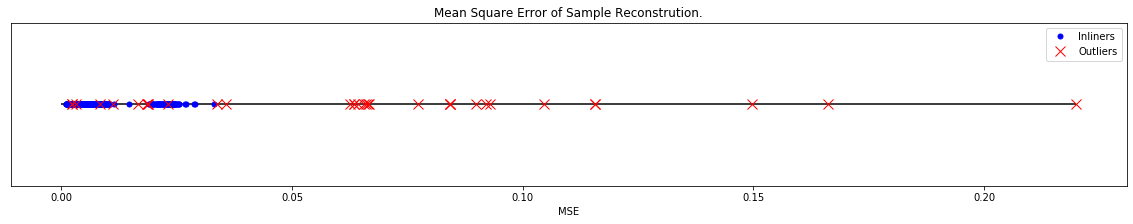

In [56]:
#Count score of autoencoder and vizualize
as_score = sum(outliers)/len(outliers) - sum(inliers)/len(inliers)
print('Score of AE: {:0.2f}mu'.format(as_score*1000))

mseVizualisation(outliers, inliers)

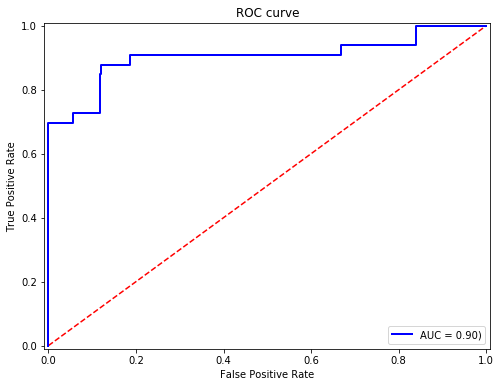

In [57]:
#Show ROC curve
rocVizualisation(y_test.to_numpy(), all_scores)

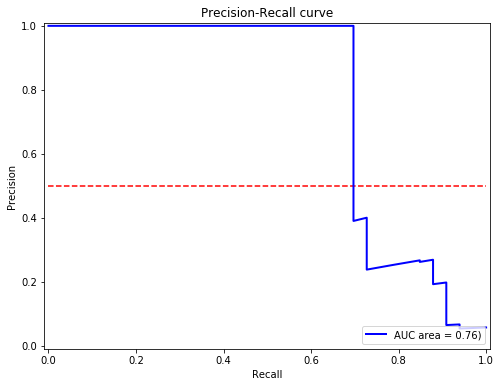

In [58]:
#Show Precision Recall curve
prec_recallVizualisation(y_test.to_numpy(), all_scores)

In [59]:
#Get optimal cut off point and check accuracy and balanced accuracy 
from sklearn.metrics import accuracy_score, balanced_accuracy_score

#Cut of point is point with highest sum of precision + recall
cut_off = getCutOff(y_test.to_numpy(), all_scores)
#If higher than cutoff point then outlier
pred = np.where(all_scores>cut_off, 1 ,0)

acc = accuracy_score(pred, y_test.to_numpy())
b_acc = balanced_accuracy_score(pred, y_test.to_numpy())

print('Accuracy score: {:.2f}%'.format(acc*100))
print('Balanced accuracy score: {:.2f}%'.format(b_acc*100))

Accuracy score: 98.40%
Balanced accuracy score: 99.17%


## 11. Explanation of Outliers

In [63]:
#Pick first 3 outliers and show worse reconstructed parameters
reconstruction = reconstruction_t.cpu().detach().numpy()

outliers_rec = reconstruction[y_test == 1][:3]
print('Parameters with highest reconstruction error for outliers: \n')
for i in outliers_rec:
    args = i.argsort()[-15:][::-1] #Get biggest errors indices
    print(list(X_train.columns[args]))

Parameters with highest reconstruction error for outliers: 

['MIPattachSlopeA', 'qOverPtC', 'oroc_C_side', 'iroc_C_side', 'iroc_A_side', 'oroc_A_side', 'hasRawQA', 'dcarCP1', 'lambdaPullHighPt', 'deltaPtA', 'MIPattachSlopeC', 'deltaPt', 'highPtAPos', 'offsetdRA', 'dcar_posC_1']
['MIPattachSlopeA', 'qOverPtC', 'oroc_C_side', 'iroc_C_side', 'iroc_A_side', 'oroc_A_side', 'hasRawQA', 'dcarCP1', 'lambdaPullHighPt', 'deltaPtA', 'MIPattachSlopeC', 'deltaPt', 'highPtAPos', 'offsetdRA', 'dcar_posC_1']
['MIPattachSlopeA', 'qOverPtC', 'iroc_C_side', 'oroc_C_side', 'iroc_A_side', 'oroc_A_side', 'hasRawQA', 'dcarCP1', 'lambdaPullHighPt', 'deltaPtA', 'MIPattachSlopeC', 'deltaPt', 'highPtAPos', 'offsetdRA', 'dcar_posC_1']
